<a href="https://colab.research.google.com/github/VKSi/2020_11_GB_TimeSeries/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Временные ряды 4. Построение и оценка модели
##                                                              Обучаем и предсказываем

## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

## Ответы

### Задание №1

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 

In [ ]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [ ]:
data = data.sort_values(by=['year', 'month', 'dayofmonth'], axis = 'index')

In [ ]:
data.dayofweek.tail()

Date
2018-08-02    3
2018-08-02    3
2018-08-02    3
2018-08-02    3
2018-08-03    4
Name: dayofweek, dtype: int64

In [ ]:
data.dayofweek.head()

Date
2002-01-01    1
2002-01-01    1
2002-01-01    1
2002-01-01    1
2002-01-01    1
Name: dayofweek, dtype: int64

Видно, что последняя неделя не полная: делать ремеплинг на полных данных по сумме вообще нельзя.     
Делать по средним тоже опасно, так как можем подхватить отклонения по внитринедельному циклу.     
Будем делать по среднему, но отбрасывая последнюю неделю.

In [ ]:
df = data.resample('W').mean()

In [ ]:
df.rename(columns={'PJME_MW': 'values'}, inplace=True)

In [ ]:
df = df.astype('int')
df.tail()

,values,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-08,38459,2018,7,5,3,186,27,3,11,0,0,0
2018-07-15,36420,2018,7,12,3,193,28,3,11,0,0,0
2018-07-22,35612,2018,7,19,3,200,29,3,11,0,0,0
2018-07-29,36581,2018,7,26,3,207,30,3,11,0,0,0
2018-08-05,36568,2018,7,15,3,212,31,1,11,0,0,0


In [ ]:
df = df.iloc[:-1,:]

In [ ]:
df.tail()

,values,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-01,35911,2018,6,23,2,179,26,3,11,0,0,0
2018-07-08,38459,2018,7,5,3,186,27,3,11,0,0,0
2018-07-15,36420,2018,7,12,3,193,28,3,11,0,0,0
2018-07-22,35612,2018,7,19,3,200,29,3,11,0,0,0
2018-07-29,36581,2018,7,26,3,207,30,3,11,0,0,0


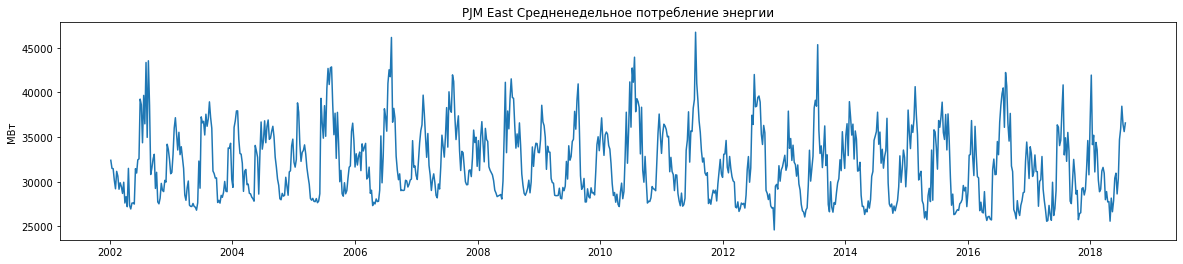

In [ ]:
plt.figure(figsize =(20,4))
plt.plot( df.index, df['values'])
plt.title('PJM East Средненедельное потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

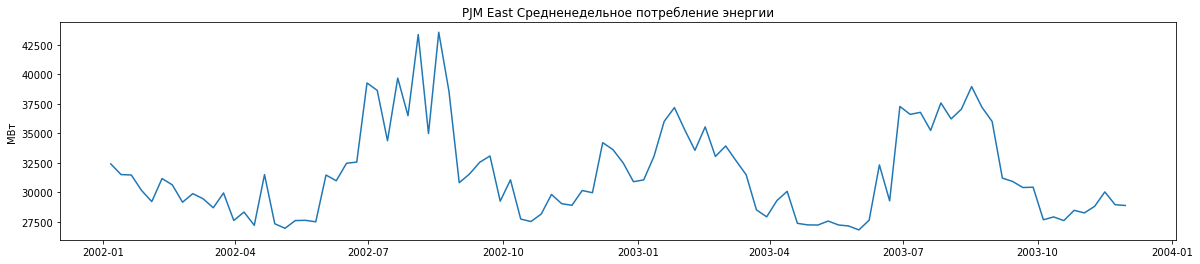

In [ ]:
plt.figure(figsize =(20,4))
plt.plot( df.head(100).index, df['values'].head(100))
plt.title('PJM East Средненедельное потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

### Задание №2

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

##### Готовим данные

Удаляем данные порядка ниже недели

In [ ]:
df.columns

Index(['values', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear',
       'weekofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday'],
      dtype='object')

In [ ]:
df.shape

(865, 12)

In [ ]:
df.drop(['dayofmonth', 'dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday'], axis='columns', inplace=True)
df.tail(10)

,values,year,month,quarter,weekofyear
Date,,,,,
2018-05-27,30382,2018,5,2,21
2018-06-03,30945,2018,5,2,22
2018-06-10,28615,2018,6,2,23
2018-06-17,30316,2018,6,2,24
2018-06-24,34711,2018,6,2,25
2018-07-01,35911,2018,6,2,26
2018-07-08,38459,2018,7,3,27
2018-07-15,36420,2018,7,3,28
2018-07-22,35612,2018,7,3,29


В лекции убирается еще и год, потому что нет тренда. Но чисто визуально он есть. Я оставлю.

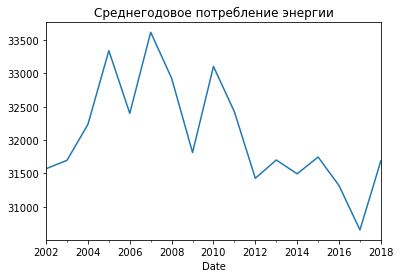

In [ ]:
df['values'].resample('Y').mean().plot()
plt.title('Среднегодовое потребление энергии')
plt.show()

##### Добавим в данные результат кластеризации:

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

In [ ]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = df.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

In [ ]:
clast_0 = DBSCAN(eps=5, leaf_size=15)
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

In [ ]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ', len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  4


Что-то с масштабированием пошло не так. Так как модуль DBSCAN подробно не разбирали, просто будем довольствоваться вариантом с tsne

C:\Users\Me\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


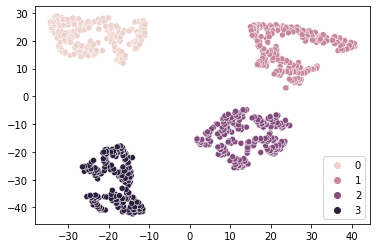

In [ ]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

Добавим полученный признак в модель 

In [ ]:
df['claster'] = X_clast

In [ ]:
for c in np.unique(X_clast):
    print(df.loc[df['claster']==c, 'month'].unique())

[1 2 3 4]
[4 5 6 7]
[ 7  8  9 10]
[10 11 12]


Видно, что кластеры фактически повторяют кварталы, но есть небольшие отклонения

NB! Мария, возвращаясь к вопросу iloc. Долго смотрел на запись     

     data_d.iloc[np.where(data_d['day_week_month']==0)[0]].iloc[:10,:]     
     
пытаясь вникнуть, что она значит.     
Когда разобрался понял, что это оказывается просто     

     data_d[data_d['day_week_month']==0].head(10)     
     
Мне кажется тут не только вопрос удобочитаемости, но и производительности: Вы же на формулу наворачиваете аж две лишние конструкции (np.where и iloc). Хотя я могу ошибаться.

##### Добавим в данные результат понижения размерности:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:-1])
Xpca.shape

(865, 2)

In [ ]:
df['pca1']=Xpca[:,0]
df['pca2']=Xpca[:,1]

##### Добавим к нашей модели 1-е разности.

In [ ]:
df['diff1'] = 0
df['diff1'].values[1:] = df.iloc[1:,0].values - df.iloc[:-1,0].values
df['diff1'].fillna(0, inplace=True)

In [ ]:
df.head()

,values,year,month,quarter,weekofyear,claster,pca1,pca2,diff1
Date,,,,,,,,,
2002-01-06,32392,2002,1,1,1,0,0.035234,2.263635,0
2002-01-13,31487,2002,1,1,2,0,0.035234,2.263635,-905
2002-01-20,31452,2002,1,1,3,0,0.035234,2.263635,-35
2002-01-27,30141,2002,1,1,4,0,0.035234,2.263635,-1311
2002-02-03,29196,2002,1,1,5,0,0.035234,2.263635,-945


In [ ]:
df['diff1_d'] = 0
df.iloc[1:, -1] = df.iloc[1:, -2]/df.iloc[1:, 0]

df.head()

,values,year,month,quarter,weekofyear,claster,pca1,pca2,diff1,diff1_d
Date,,,,,,,,,,
2002-01-06,32392,2002,1,1,1,0,0.035234,2.263635,0,0.000000
2002-01-13,31487,2002,1,1,2,0,0.035234,2.263635,-905,-0.028742
2002-01-20,31452,2002,1,1,3,0,0.035234,2.263635,-35,-0.001113
2002-01-27,30141,2002,1,1,4,0,0.035234,2.263635,-1311,-0.043496
2002-02-03,29196,2002,1,1,5,0,0.035234,2.263635,-945,-0.032367


In [ ]:
df.shape

(865, 10)

##### Добавим скользящие средние и экспоненциальные средние

На 3-м уроке мы определили с помощью сетки по модели SARIMAX, что лучшие параметры (с учетом минимальной сложности модели) будут (1, 1, 2)(0, 1, 2, 52)

Учитывая эти результаты добавим МА только низкого порядка. Если добавить годовое сглаживание, то это приведет к потере 6% данных.

In [ ]:
for m in [1, 2, 52]:
    df[f'ma_{m}'] = df['values'].rolling(window=m).mean()
    df[f'ma_{m}'].fillna(0, inplace=True)

In [ ]:
df.columns

Index(['values', 'year', 'month', 'quarter', 'weekofyear', 'claster', 'pca1',
       'pca2', 'diff1', 'diff1_d', 'ma_1', 'ma_2', 'ma_52'],
      dtype='object')

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
for alpha in range(1, 10, 2):
    df[f'ema_{alpha/100}'.replace('.', '')] = exponential_smoothing(df['values'], alpha/100)

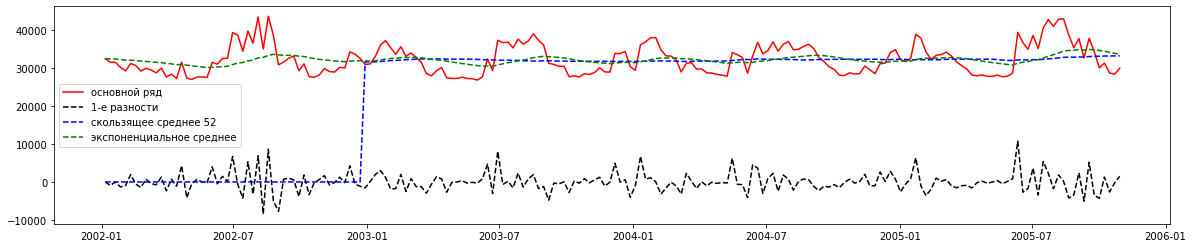

In [ ]:
N = 200
plt.figure(figsize =(20,4))
plt.plot(df.index[:N], df['values'][:N],'r',label ='основной ряд')
plt.plot(df.index[:N], df['diff1'][:N],'--k',label ='1-е разности')
plt.plot(df.index[:N], df['ma_52'][:N],'--b',label ='скользящее среднее 52')
plt.plot(df.index[:N], df['ema_005'][:N],'--g',label ='экспоненциальное среднее')
plt.legend()
plt.show()

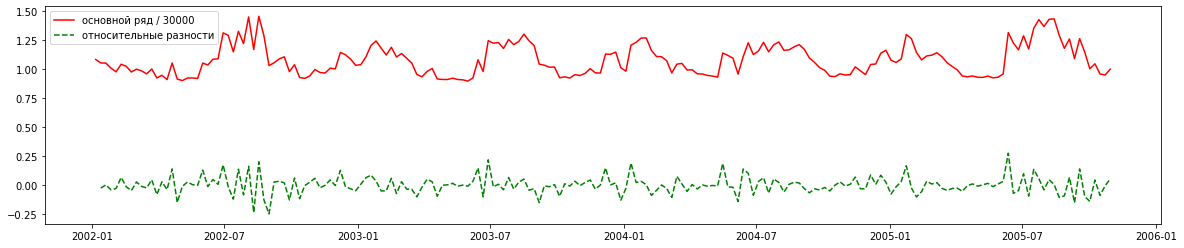

In [ ]:
plt.figure(figsize =(20,4))
plt.plot(df.index[:N], df['values'][:N]/30000,'r',label ='основной ряд / 30000')
plt.plot(df.index[1:N], df['diff1_d'][1:N],'--g',label ='относительные разности')
plt.legend()
plt.show()

##### Добавим истории длиной p в признаках автокорреляции для оргинальных данных и для разности

In [ ]:
p = 2
for i in range(p):
    df[f't_{p-i}'] = 0
    df[f't_{p-i}'].values[p:] = df['values'].values[i: -(p -i)]
    df[f't_{p-i}'].fillna(0, inplace=True)
    
    df[f'd_{p-i}'] = 0
    df[f'd_{p-i}'].values[p:] = df['diff1'].values[i: -(p -i)]
    df[f'd_{p-i}'].fillna(0, inplace=True)

In [ ]:
df.columns

Index(['values', 'year', 'month', 'quarter', 'weekofyear', 'claster', 'pca1',
       'pca2', 'diff1', 'diff1_d', 'ma_1', 'ma_2', 'ma_52', 'ema_001',
       'ema_003', 'ema_005', 'ema_007', 'ema_009', 't_2', 'd_2', 't_1', 'd_1'],
      dtype='object')

In [ ]:
df.shape

(865, 22)

В итоге данные примут вид 

In [ ]:
df.head(15)

,values,year,month,quarter,weekofyear,claster,pca1,pca2,diff1,diff1_d,...,ma_52,ema_001,ema_003,ema_005,ema_007,ema_009,t_2,d_2,t_1,d_1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392,2002,1,1,1,0,0.035234,2.263635,0,0.000000,...,0.0,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,0,0,0,0
2002-01-13,31487,2002,1,1,2,0,0.035234,2.263635,-905,-0.028742,...,0.0,32382.950000,32364.850000,32346.750000,32328.650000,32310.550000,0,0,0,0
2002-01-20,31452,2002,1,1,3,0,0.035234,2.263635,-35,-0.001113,...,0.0,32373.640500,32337.464500,32302.012500,32267.284500,32233.280500,32392,0,31487,-905
2002-01-27,30141,2002,1,1,4,0,0.035234,2.263635,-1311,-0.043496,...,0.0,32351.314095,32271.570565,32193.961875,32118.444585,32044.975255,31487,-905,31452,-35
2002-02-03,29196,2002,1,1,5,0,0.035234,2.263635,-945,-0.032367,...,0.0,32319.760954,32179.303448,32044.063781,31913.873464,31788.567482,31452,-35,30141,-1311
2002-02-10,31150,2002,2,1,6,0,0.244071,2.054798,1954,0.062729,...,0.0,32308.063345,32148.424345,31999.360592,31860.402322,31731.096409,30141,-1311,29196,-945
2002-02-17,30616,2002,2,1,7,0,0.244071,2.054798,-534,-0.017442,...,0.0,32291.142711,32102.451614,31930.192563,31773.294159,31630.737732,29196,-945,31150,1954
2002-02-24,29144,2002,2,1,8,0,0.244071,2.054798,-1472,-0.050508,...,0.0,32259.671284,32013.698066,31790.882934,31589.243568,31406.931336,31150,1954,30616,-534
2002-03-03,29869,2002,2,1,9,0,0.244071,2.054798,725,0.024273,...,0.0,32235.764571,31949.357124,31694.788788,31468.826518,31268.517516,30616,-534,29144,-1472


##### Отбираем лучшие признаки

Хотя у нас не так много признаков и этот шаг можно было бы, наверное, пропустить, пройдем по нему чтобы закрепить материал

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 4, тогда target = y(t+h)=y(t+1) 

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [ ]:
def X_y_prep(data, h, p):
    scl_target = StandardScaler() 
    scl_x = StandardScaler() 

    target = data['values'].values[h + p:].reshape((df.shape[0] - h - p, 1))
    y = scl_target.fit_transform(target)

    X = data.iloc[p : -h, :].values
    X = scl_x.fit_transform(X.astype('float64'))

    assert(y.shape[0] == X.shape[0])
    
    return X, y, scl_target, scl_x

In [ ]:
X, y, scl_target_4, scl_x_4 = X_y_prep(df.copy(), h=4, p=52) # Проверим сначала на полном наборе, включая 52 недельное сглаживание

In [ ]:
y.shape

(809, 1)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
def range_feat(X, y, feat_names):
    f_test, _ = f_regression(X, y.ravel())
    f_test /= np.max(f_test)
    for i in range(X.shape[1]):
        print("F-test={:.2f},  feature={},      \t I={}".format(f_test[i], feat_names[i], i))

In [ ]:
range_feat(X, y, df.columns)

F-test=1.00,  feature=values,      	 I=0
F-test=0.07,  feature=year,      	 I=1
F-test=0.02,  feature=month,      	 I=2
F-test=0.02,  feature=quarter,      	 I=3
F-test=0.02,  feature=weekofyear,      	 I=4
F-test=0.02,  feature=claster,      	 I=5
F-test=0.08,  feature=pca1,      	 I=6
F-test=0.01,  feature=pca2,      	 I=7
F-test=0.19,  feature=diff1,      	 I=8
F-test=0.19,  feature=diff1_d,      	 I=9
F-test=1.00,  feature=ma_1,      	 I=10
F-test=0.76,  feature=ma_2,      	 I=11
F-test=0.05,  feature=ma_52,      	 I=12
F-test=0.00,  feature=ema_001,      	 I=13
F-test=0.08,  feature=ema_003,      	 I=14
F-test=0.13,  feature=ema_005,      	 I=15
F-test=0.12,  feature=ema_007,      	 I=16
F-test=0.09,  feature=ema_009,      	 I=17
F-test=0.10,  feature=t_2,      	 I=18
F-test=0.29,  feature=d_2,      	 I=19
F-test=0.43,  feature=t_1,      	 I=20
F-test=0.24,  feature=d_1,      	 I=21


Проверка показывает, что ma_52 имеет слабую линейную связь с таргетом. Пока не будем рассматривать остальные признаки, а проверим важность m_52 для h = 1:

In [ ]:
X, y, scl_target_1, scl_x_1 = X_y_prep(df.copy(), h=1, p=52)
range_feat(X, y, df.columns)

F-test=1.00,  feature=values,      	 I=0
F-test=0.01,  feature=year,      	 I=1
F-test=0.00,  feature=month,      	 I=2
F-test=0.00,  feature=quarter,      	 I=3
F-test=0.00,  feature=weekofyear,      	 I=4
F-test=0.00,  feature=claster,      	 I=5
F-test=0.00,  feature=pca1,      	 I=6
F-test=0.01,  feature=pca2,      	 I=7
F-test=0.02,  feature=diff1,      	 I=8
F-test=0.02,  feature=diff1_d,      	 I=9
F-test=1.00,  feature=ma_1,      	 I=10
F-test=0.90,  feature=ma_2,      	 I=11
F-test=0.01,  feature=ma_52,      	 I=12
F-test=0.01,  feature=ema_001,      	 I=13
F-test=0.01,  feature=ema_003,      	 I=14
F-test=0.02,  feature=ema_005,      	 I=15
F-test=0.04,  feature=ema_007,      	 I=16
F-test=0.06,  feature=ema_009,      	 I=17
F-test=0.29,  feature=t_2,      	 I=18
F-test=0.02,  feature=d_2,      	 I=19
F-test=0.51,  feature=t_1,      	 I=20
F-test=0.02,  feature=d_1,      	 I=21


Здесь ситуация такая же. Избавимся сразу от этого признака и будем использовать более полный набор данных

In [ ]:
df.drop('ma_52', axis='columns', inplace=True)

In [ ]:
h = 4
p = 2

In [ ]:
X_4_2, y_4_2, scl_target_4, scl_x_4 = X_y_prep(df.copy(), h=4, p=2)
range_feat(X_4_2, y_4_2, df.columns)

F-test=1.00,  feature=values,      	 I=0
F-test=0.05,  feature=year,      	 I=1
F-test=0.03,  feature=month,      	 I=2
F-test=0.03,  feature=quarter,      	 I=3
F-test=0.02,  feature=weekofyear,      	 I=4
F-test=0.03,  feature=claster,      	 I=5
F-test=0.07,  feature=pca1,      	 I=6
F-test=0.00,  feature=pca2,      	 I=7
F-test=0.18,  feature=diff1,      	 I=8
F-test=0.18,  feature=diff1_d,      	 I=9
F-test=1.00,  feature=ma_1,      	 I=10
F-test=0.77,  feature=ma_2,      	 I=11
F-test=0.01,  feature=ema_001,      	 I=12
F-test=0.08,  feature=ema_003,      	 I=13
F-test=0.13,  feature=ema_005,      	 I=14
F-test=0.12,  feature=ema_007,      	 I=15
F-test=0.09,  feature=ema_009,      	 I=16
F-test=0.11,  feature=t_2,      	 I=17
F-test=0.25,  feature=d_2,      	 I=18
F-test=0.43,  feature=t_1,      	 I=19
F-test=0.23,  feature=d_1,      	 I=20


In [ ]:
y_4_2.shape

(859, 1)

Проверка через F-test показывает, что есть корреляционная связь с предшествующими значением ряда (признаки values, t_1, t_2), корреляция увеличивается для более быстрых ЕМА, есть связь с обоими МА.     
Применим автоматизацию выбора через SelectKBest c выделением 7 лучших признаков.

In [ ]:
sfk =SelectKBest(f_regression, k=7)
X_new_4_2 =sfk.fit_transform(X_4_2, y_4_2.ravel())
X_new_4_2.shape

(859, 7)

In [ ]:
column_names = df.columns[sfk.get_support()]
column_names

Index(['values', 'diff1_d', 'ma_1', 'ma_2', 'd_2', 't_1', 'd_1'], dtype='object')

##### Разделение данных на тестовые и тренировочные 

In [ ]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

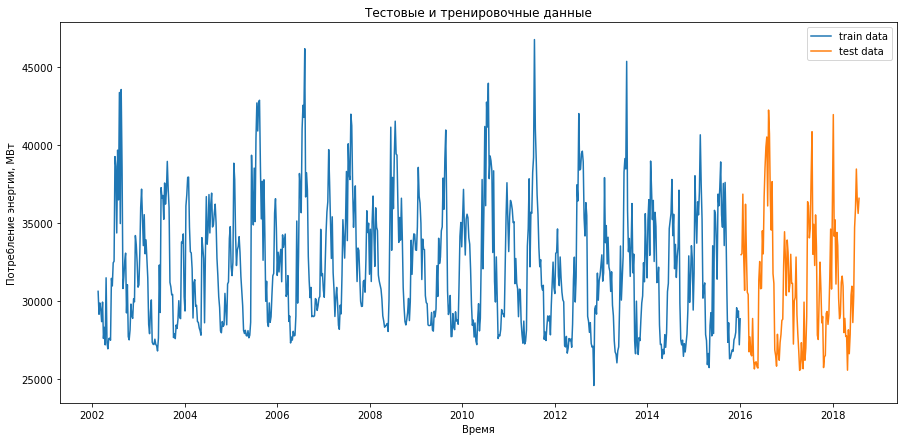

In [ ]:
train, test = split_data(df.iloc[p + h:, :].copy(), '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['values'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['values'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [ ]:
train.shape

(725, 21)

In [ ]:
test.shape

(134, 21)

In [ ]:
train.shape[0]+test.shape[0]

859

In [ ]:
X_new_4_2.shape

(859, 7)

In [ ]:
X_train = X_new_4_2[:train.shape[0], :]
y_train = y_4_2[:train.shape[0], 0]
X_test = X_new_4_2[train.shape[0]:, :]
y_test = y_4_2[train.shape[0]:, 0]

In [ ]:
X_train.shape

(725, 7)

In [ ]:
X_test.shape

(134, 7)

In [ ]:
X_train.shape[0] + X_test.shape[0]

859

##### Строим Модель

In [ ]:
h = 4
p = 2

Построим модель GradientBoostingRegressor (только для сравнимости, потому, что использовали эту модель в лекции)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [ ]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=0)

In [ ]:
X_test.shape

(134, 7)

In [ ]:
y_test_pred_g = model_g.predict(X_test)

In [ ]:
y_test_pred_g.shape

(134,)

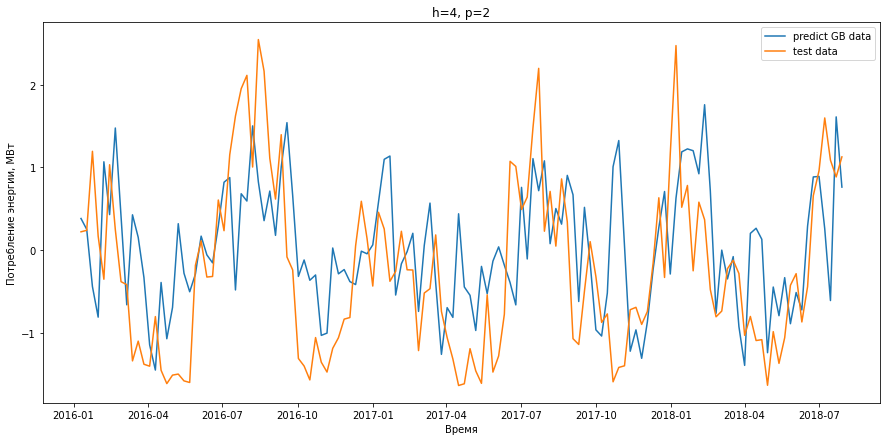

In [ ]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index, y_test_pred_g, label='predict GB data' )
plt.plot(test.index, y_test, label='test data')

plt.legend()
plt.title('h=4, p=2')
plt.show()

##### Оценки для сравнения моделей

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.9445165046010301 
ошибка mae  :   0.788271987809211 
оценка R2 :   0.08766145263205238


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scl_target = scl_target_4

In [ ]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),
                                      y_pred = scl_target.inverse_transform(y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   10.310698328274329 %


Анализ на отсутствие корреляции с последующим ответом (проверяем не делаем ли предсказание в стиле "завтра==сегодня")

In [ ]:
def corr_lag_plot(y_test, y_test_pred_g, lag=10):
    lag=10
    p_cor=[np.corrcoef(y_test, y_test_pred_g)[1,0]]
    for i in range(lag):
        c=np.corrcoef(y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
        p_cor.append(c)    

    plt.plot(np.array(p_cor) )  
    plt.xlabel('лаг корреляции')
    plt.ylabel('cor_coeff')
    plt.title('корреляция цели и предсказаний с лагом просмотра')
    plt.show()

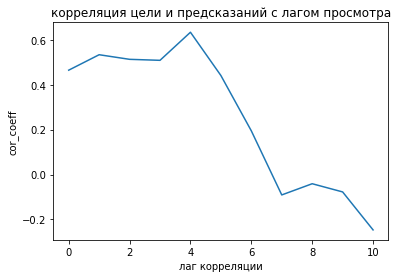

In [ ]:
corr_lag_plot(y_test, y_test_pred_g)

Ух ты, как все плохо!

##### Попробуем оптимизировать параметры

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_dist = {"max_depth": [3, 2, 10, 14, 5], 
              "n_estimators":[100, 200, 300 ,400, 500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr = GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)
random_search.fit(X_train, y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.272 (std: 0.063)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.250 (std: 0.060)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.200 (std: 0.054)
Parameters: {'n_estimators': 300, 'max_depth': 3}



C:\Users\Me\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Выбираем модель с рангом 1. {'n_estimators': 100, 'max_depth': 3} (в одном из запусков RandomizedSearchCV был лучший резльтат) и проведем ее обучение на тренировочном наборе.

In [ ]:
model_g_best_4_2 = GradientBoostingRegressor(max_depth=3,  n_estimators=100)
model_g_best_4_2.fit( X_train, y_train ) 
y_test_pred_g_4_2 = model_g_best_4_2.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),
                                      y_pred = scl_target.inverse_transform(y_test_pred_g_4_2))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   10.278214284751753 %


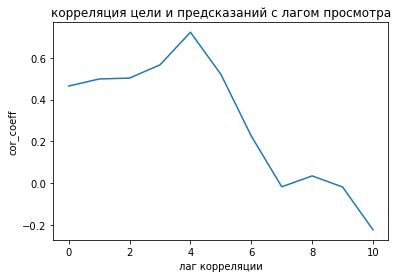

In [ ]:
corr_lag_plot(y_test, y_test_pred_g_4_2)

Улучшения нет (((

### Задание №3

2. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [ ]:
h = 1
p = 2

In [ ]:
train, test = split_data(df.iloc[p + h:, :].copy(), '01-06-2016')
X_1_2, y_1_2, scl_target_1, scl_x_1 = X_y_prep(df.copy(), h, p)

In [ ]:
sfk =SelectKBest(f_regression, k=7)
X_new_1_2 =sfk.fit_transform(X_1_2, y_1_2.ravel())
X_new_1_2.shape

(862, 7)

In [ ]:
X_train =X_new_1_2[:train.shape[0],:]
y_train =y_1_2[:train.shape[0],0]
X_test =X_new_1_2[train.shape[0]:,:]
y_test =y_1_2[train.shape[0]:,0]

In [ ]:
X_train.shape

(728, 7)

In [ ]:
X_test.shape

(134, 7)

In [ ]:
X_train.shape[0] + X_test.shape[0]

862

In [ ]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [ ]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=0)

In [ ]:
y_test_pred_g_1_2 = model_g.predict(X_test)

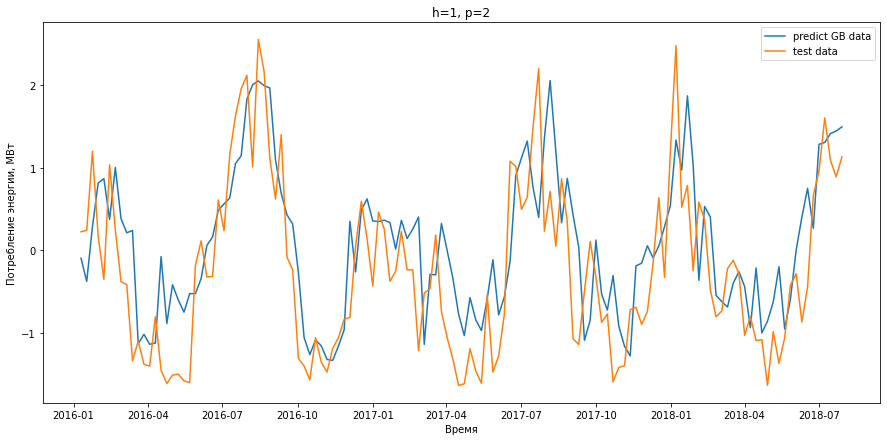

In [ ]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index, y_test_pred_g_1_2, label='predict GB data' )
plt.plot(test.index, y_test, label='test data')

plt.legend()
plt.title('h=1, p=2')
plt.show()

In [ ]:
scl_target = scl_target_1

In [ ]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),
                                      y_pred = scl_target.inverse_transform(y_test_pred_g_1_2))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.891732605647775 %


Анализ на отсутствие корреляции с последующим ответом (проверяем не делаем ли предсказание в стиле "завтра==сегодня")

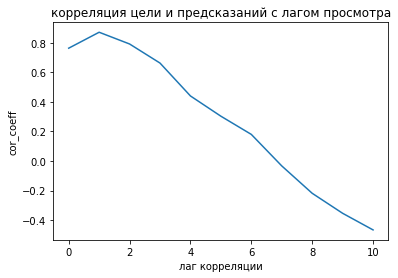

In [ ]:
corr_lag_plot(y_test, y_test_pred_g_1_2)

Значительно лучше, чем для h=4, но все равно не оптимально

In [ ]:
param_dist = {"max_depth": [3, 2, 10, 14, 5], 
              "n_estimators":[100, 200, 300 ,400, 500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr = GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)
random_search.fit(X_train, y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.641 (std: 0.045)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.634 (std: 0.048)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.576 (std: 0.059)
Parameters: {'n_estimators': 200, 'max_depth': 5}



C:\Users\Me\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Выбираем модель с рангом 1. {'n_estimators': 500, 'max_depth': 2} и проведем ее обучение на тренировочном наборе.

In [ ]:
model_g_best_1_2 = GradientBoostingRegressor(max_depth=2,  n_estimators=500)
model_g_best_1_2.fit(X_train, y_train ) 
y_test_pred_g_1_2 = model_g_best_1_2.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),
                                      y_pred = scl_target.inverse_transform(y_test_pred_g_1_2))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.299511215905212 %


In [ ]:
y_test_pred_g_1_2 = model_g_best.predict(X_test)

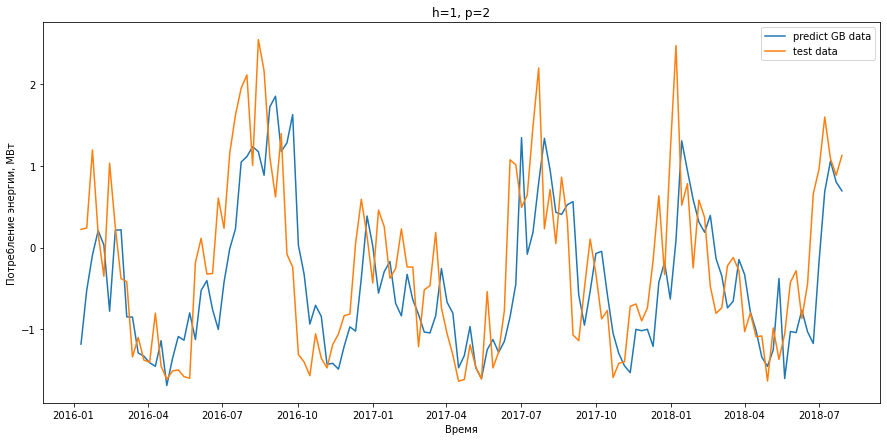

In [ ]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index, y_test_pred_g_1_2, label='predict GB data' )
plt.plot(test.index, y_test, label='test data')

plt.legend()
plt.title('h=1, p=2')
plt.show()

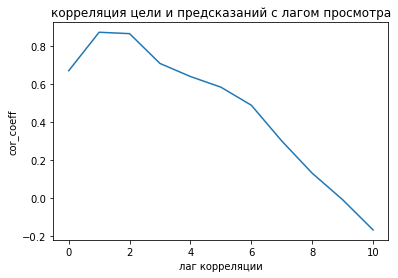

In [ ]:
corr_lag_plot(y_test, y_test_pred_g_1_2)

И опять оптимизация не улучшила результат (((

### Задание №4

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [ ]:
column_names

Index(['values', 'diff1_d', 'ma_1', 'ma_2', 'd_2', 't_1', 'd_1'], dtype='object')

In [ ]:
scl_target = scl_target_1
scl_x = scl_x_1
h = 4

In [ ]:
y_test_pred_rec = np.zeros(len(y_test))
# Внешний цикл по всем точкам ОТ которых ведем предсказание:
for t in range(p, len(y_test) - h):
    # Внутренний цикл по всем точкам рекурсии на h вперед:
    # Сбрасываем к начальному значению тестовой выборки
    X_test_rec = X_test.copy()  
    y_test_rec = y_test.copy()
    for i in range(t, t + h):
        # делаем прдсказание для первой точки
        y_test_rec[i] = model_g_best_1_2.predict(X_test_rec[i, :].reshape((1, X_test_rec.shape[1])))
        # восстанавливаем не масштабированное значение ряда текущей точке  
        y_i = scl_target.inverse_transform(y_test_rec[i : i + 1]  )

        # заполняем вектор для прогноза следующей точки
        # values
        X_test_rec[i + 1, 0] = (y_i - scl_x.mean_[0]) / scl_x.scale_[0]

        # diff1_d
        diff1 = X_test_rec[i + 1, 0] - X_test_rec[i, 0]
        X_test_rec[i + 1, 1] = diff1 / X_test_rec[i + 1, 0]

        # ma_1
        X_test_rec[i + 1, 2] = np.mean(X_test_rec[i : i + 1, 0])

        # ma_2
        X_test_rec[i + 1, 3] = np.mean(X_test_rec[i - 1 : i + 1, 0])

        # t_1
        X_test_rec[i + 1, 5] = X_test_rec[i, 0]

        # d_1
        X_test_rec[i + 1, 6] = X_test_rec[i, 0] - X_test_rec[i - 1, 0]

        # d_2
        X_test_rec[i + 1, 4] = X_test_rec[i - 1, 0] - X_test_rec[i - 2, 0] 
    
    y_test_pred_rec[t + h] = X_test_rec[t + h, 0]

In [ ]:
N = 50

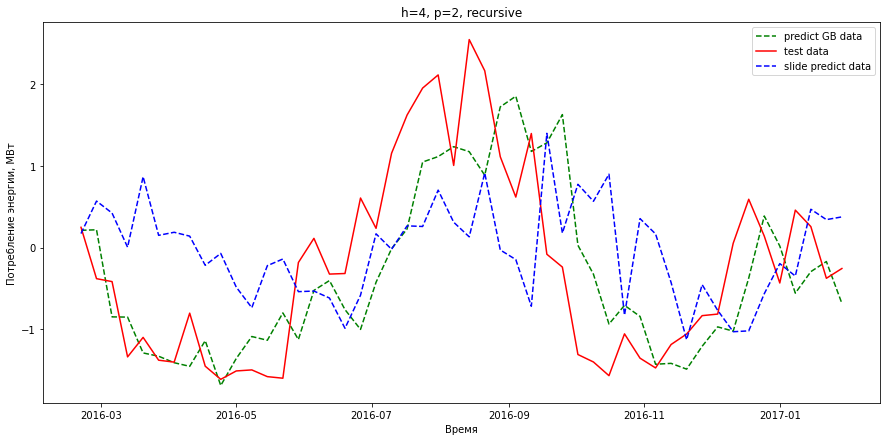

In [ ]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h + p: N + h + p], y_test_pred_g_1_2[h + p: N + h + p], '--g', label='predict GB data' )
plt.plot(test.index[h + p: N + h + p], y_test[h + p: N + h + p], 'r', label='test data')
plt.plot(test.index[h + p: N + h + p], y_test_pred_rec[h + p: N + h + p], '--b', label='slide predict data')

plt.legend()
plt.title('h=4, p=2, recursive')
plt.show()

In [ ]:
y_true = scl_target.inverse_transform(y_test[p + h :]),
y_pred = scl_target.inverse_transform(y_test_pred_rec[p + h :])

In [ ]:
er_g = mean_absolute_percentage_error(y_true = y_true,
                                      y_pred = y_pred)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   12.20639716553505 %


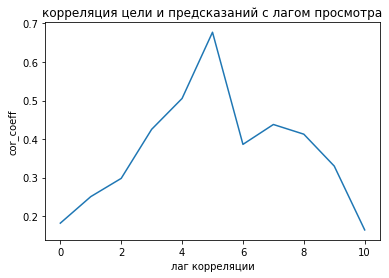

In [ ]:
corr_lag_plot(y_test[p + h :], y_test_pred_rec[p + h :])

Предсказание через рекурсию получилось хуже, чем для прямого предсказания h=4     
Какой-то дикий ужас (((

### Задание №5

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [ ]:
p = 2
er_g = []
for h in range(1, 101):
    scl_target = scl_target_1
    scl_x = scl_x_1

    y_test_pred_rec = np.zeros(len(y_test))
    # Внешний цикл по всем точкам ОТ которых ведем предсказание:
    for t in range(p, len(y_test) - h):
        # Внутренний цикл по всем точкам рекурсии на h вперед:
        # Сбрасываем к начальному значению тестовой выборки
        X_test_rec = X_test.copy()  
        y_test_rec = y_test.copy()
        for i in range(t, t + h):
            # делаем прдсказание для первой точки
            y_test_rec[i] = model_g_best_1_2.predict(X_test_rec[i, :].reshape((1, X_test_rec.shape[1])))
            # восстанавливаем не масштабированное значение ряда текущей точке  
            y_i = scl_target.inverse_transform(y_test_rec[i : i + 1]  )

            # заполняем вектор для прогноза следующей точки
            # values
            X_test_rec[i + 1, 0] = (y_i - scl_x.mean_[0]) / scl_x.scale_[0]

            # diff1_d
            diff1 = X_test_rec[i + 1, 0] - X_test_rec[i, 0]
            X_test_rec[i + 1, 1] = diff1 / X_test_rec[i + 1, 0]

            # ma_1
            X_test_rec[i + 1, 2] = np.mean(X_test_rec[i : i + 1, 0])

            # ma_2
            X_test_rec[i + 1, 3] = np.mean(X_test_rec[i - 1 : i + 1, 0])

            # t_1
            X_test_rec[i + 1, 5] = X_test_rec[i, 0]

            # d_1
            X_test_rec[i + 1, 6] = X_test_rec[i, 0] - X_test_rec[i - 1, 0]

            # d_2
            X_test_rec[i + 1, 4] = X_test_rec[i - 1, 0] - X_test_rec[i - 2, 0] 

        y_test_pred_rec[t + h] = X_test_rec[t + h, 0]
    
    y_true = scl_target.inverse_transform(y_test[p + h :]),
    y_pred = scl_target.inverse_transform(y_test_pred_rec[p + h :])
    
    er_g.append(mean_absolute_percentage_error(y_true = y_true,
                                      y_pred = y_pred))

In [ ]:
mean_er_g = {key*10:value for key, value in enumerate(np.array(er_g).reshape(10, 10).mean(axis=1))}

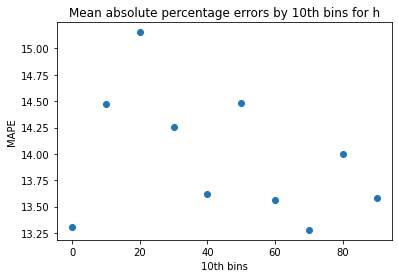

In [ ]:
plt.scatter(x = mean_er_g.keys(), y = mean_er_g.values())
plt.ylabel('MAPE')
plt.xlabel('10th bins')
plt.title('Mean absolute percentage errors by 10th bins for h')
plt.show()

### Задание №6

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Сначала ошибка резко выросла, но затем начала падать.